# WeatherNet V2
* has new generator for .npy files

In [1]:
data_dir = '/Volumes/Samsung_T5/WeatherNet/Make_NP_DataSet/data_npy'

## Import modules

In [17]:
# A. General
import os

# B. Datafile manipulation
from PIL import Image
import pandas as pd
import glob 

# C. Numeric operations
import numpy as np 
from random import shuffle
from itertools import chain

# D. DataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

# E. Machine Learning
# E.1 Keras model layers
from tensorflow.keras.layers import Input, ConvLSTM2D, Concatenate,\
    TimeDistributed, SeparableConv2D, GlobalAveragePooling2D, Dense,GlobalAveragePooling3D

# E.2 General TF and Keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import classification_report

## Declare path to data 

In [26]:
train_path = data_dir + "/train"
val_path = data_dir + "/val"
test_path = data_dir + "/test"

train_flir = train_path + "/flir"
train_top = train_path + "/top"
train_bottom = train_path + "/bottom"

val_flir = val_path + "/flir"
val_top = val_path + "/top"
val_bottom = val_path + "/bottom"

test_flir = test_path + "/flir"
test_top = test_path + "/top"
test_bottom = test_path + "/bottom"

## Generator Class

In [4]:
class SeqDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, path_1, path_2, path_3, batch_size=32, dim=(6,32,32,32), 
                 n_classes=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        self.flir_path = path_1
        self.bottom_path = path_2
        self.top_path = path_3
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp,indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp,indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_flir = np.empty((self.batch_size, *self.dim))
        X_bottom = np.empty((self.batch_size, *self.dim))
        X_top = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X_flir[i,] = np.load(self.flir_path + '/' + ID)
            X_bottom[i,] = np.load(self.bottom_path + '/' + ID)
            X_top[i,] = np.load(self.top_path + '/' + ID)

        for i , index in enumerate(indexes):    
            # Store class
            y[i] = self.labels[index]
            
        return [X_flir,X_bottom,X_top], to_categorical(y, num_classes=self.n_classes)

## Declare Train Generator

In [5]:
# Parameters
# dim ~ (# frames per seq, channels, height, width)
params = {'dim': (6,3,480,640),
          'batch_size': 32,
          'n_classes': 3,
          'shuffle': True}

# Datasets
input_train = [os.path.basename(name) for i,name in enumerate(glob.glob(train_flir+"/*.npy"))]
labels_train = [label.split("_")[-1] for i,label in enumerate(input_train)]
labels_train = [label.split(".")[0] for i,label in enumerate(labels_train)]

labels = ["low","mid","high"]

for i in range(len(labels_train)):
    if labels_train[i] == "low":
        labels_train[i] = 0
    elif labels_train[i] == "mid":
        labels_train[i] = 1
    else:
        labels_train[i] = 2           

# Generators
train_gen = SeqDataGenerator(input_train, labels_train,train_flir,\
                                      train_bottom,train_top, **params)

## Declare Val generator

In [6]:
# Parameters
# dim ~ (# frames per seq, channels, height, width)
params = {'dim': (6,3,480,640),
          'batch_size': 64,
          'n_classes': 3,
          'shuffle': True}

# Datasets
input_val = [os.path.basename(name) for i,name in enumerate(glob.glob(val_flir+"/*.npy"))]
labels_val = [label.split("_")[-1] for i,label in enumerate(input_val)]
labels_val = [label.split(".")[0] for i,label in enumerate(labels_val)]

labels = ["low","mid","high"]

for i in range(len(labels_val)):
    if labels_val[i] == "low":
        labels_val[i] = 0
    elif labels_val[i] == "mid":
        labels_val[i] = 1
    else:
        labels_val[i] = 2           

# Generators
val_gen = SeqDataGenerator(input_val, labels_val,val_flir,\
                                      val_bottom,val_top, **params)

## Declare Model

In [7]:
# shape=(batch_size, time_steps, channels, row, col)
input_flir = Input(shape=(6,3,480,640,)) 
x_flir = TimeDistributed(SeparableConv2D(8,(4,4),padding="same"))(input_flir)

input_bottom = Input(shape=(6,3,480,640,)) 
x_bottom = TimeDistributed(SeparableConv2D(8,(4,4),padding="same"))(input_bottom)

input_top = Input(shape=(6,3,480,640,)) 
x_top = TimeDistributed(SeparableConv2D(8,(4,4),padding="same"))(input_top)

x_concat = Concatenate(axis=-1)([x_flir,x_bottom,x_top])
x_ConvLSTM2D = ConvLSTM2D(8,(4,4),padding="same",return_sequences=True)(x_concat)

x_flat = GlobalAveragePooling3D()(x_ConvLSTM2D)
yh = Dense(3,activation="softmax")(x_flat)

model = Model([input_flir,input_bottom,input_top],yh)

model.compile(loss=categorical_crossentropy,
                 optimizer=Adam(lr=.0001),
                 metrics=[tf.keras.metrics.CategoricalAccuracy()])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 3, 480, 6 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6, 3, 480, 6 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 6, 3, 480, 6 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 6, 3, 480, 8) 15368       input_1[0][0]                    
______________________________________________________________________________________________

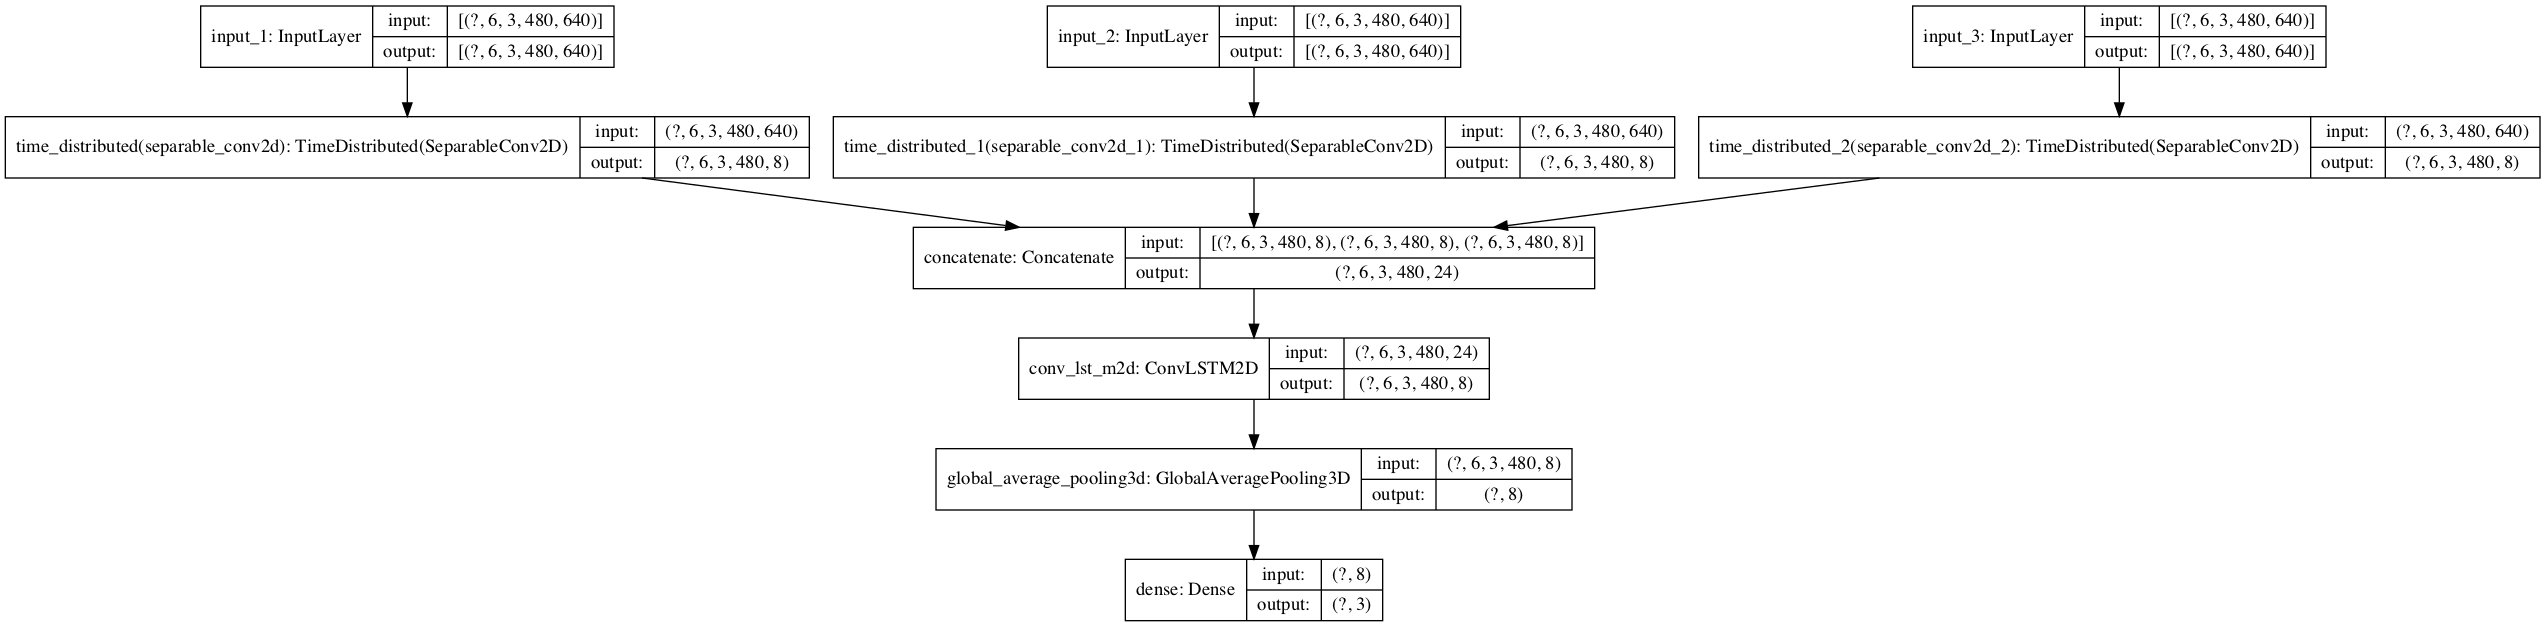

In [8]:
plot_model(model, to_file= "WeatherNet.png" , show_shapes=True, show_layer_names=True)

## Train Model

In [9]:
# Train model on dataset
model_path = "'/Volumes/Samsung_T5/WeatherNet/model.h5"
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.fit(train_gen,validation_data=val_gen,callbacks = [checkpoint],epochs=2)

Epoch 1/3
27/27 [==============================] - 902s 33s/step - loss: 1.0273 - categorical_accuracy: 0.5035 - val_loss: 0.7735 - val_categorical_accuracy: 0.8594
Epoch 2/3
27/27 [==============================] - 830s 31s/step - loss: 1.0000 - categorical_accuracy: 0.5185 - val_loss: 0.7710 - val_categorical_accuracy: 0.8086
Epoch 3/3
27/27 [==============================] - 842s 31s/step - loss: 0.9930 - categorical_accuracy: 0.5231 - val_loss: 0.7569 - val_categorical_accuracy: 0.8281


## Test Model

In [32]:
# dim ~ (# frames per seq, channels, height, width)
params = {'dim': (6,3,480,640),
          'batch_size': 60,
          'n_classes': 3,
          'shuffle': False}

# Datasets
input_test = [os.path.basename(name) for i,name in enumerate(glob.glob(test_flir+"/*.npy"))]
labels_test = [label.split("_")[-1] for i,label in enumerate(input_test)]
labels_test = [label.split(".")[0] for i,label in enumerate(labels_test)]

labels = ["low","mid","high"]

for i in range(len(labels_test)):
    if labels_test[i] == "low":
        labels_test[i] = 0
    elif labels_test[i] == "mid":
        labels_test[i] = 1
    else:
        labels_test[i] = 2           
        
# Generators
test_gen = SeqDataGenerator(input_test, labels_test,test_flir,\
                                      test_bottom,test_top, **params)

In [33]:
yh = model.predict(test_gen)

In [35]:
target_names = ['low', 'mid', 'high']
print(classification_report(labels_test, np.argmax(yh,axis=1), target_names=labels))

              precision    recall  f1-score   support

         low       0.35      0.95      0.51        20
         mid       0.00      0.00      0.00        20
        high       0.67      0.20      0.31        20

    accuracy                           0.38        60
   macro avg       0.34      0.38      0.27        60
weighted avg       0.34      0.38      0.27        60

